In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import copy
import time

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.loader import NeighborLoader, DataLoader

from src.models.nn_layers import MLPModel
from src.models.gnn_layers import MyGATConv
from src.models.ML_frameworks import GNNFramework
import src.loading as loading
import src.processing.raw_data_cleaning as raw_data_cleaning

from src.visualization.analyse_model import plot_errors_labels_comparison, get_prediction_table

from src.pipeline import GeneralizerRun 
import src.processing.preprocessing as preprocessing

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
data = loading.load_data()

== Load Data: start ==
== Load Data: end ==


start participant_id/n_participants-1:10/112
Test function convert_table_to_graph
Data(x=[60, 2], edge_index=[2, 3540], edge_attr=[3540, 1], y=[60, 1], x_names=[2], edge_attr_names=[1], y_names=[1], train_mask=[60], val_mask=[60])
validate: True
is undirected: True
has_self_loop: tensor(False)
end Test function convert_table_to_graph
Preprocessing 1
Number of Edges before transform: 3540
Number of Edges after transform: 2929
Preprocessing 2
Preprocessing 3
Model
my_module.bias None
== start training ==
epoch: 1/10000,
 train_loss: 0.8794,
 train_mae: 0.8015,
 epoch_time_duration: 0.0038

epoch: 2/10000,
 train_loss: 0.8672,
 train_mae: 0.7811,
 epoch_time_duration: 0.0044

epoch: 3/10000,
 train_loss: 0.8683,
 train_mae: 0.7831,
 epoch_time_duration: 0.0038

epoch: 4/10000,
 train_loss: 0.8616,
 train_mae: 0.7937,
 epoch_time_duration: 0.0034

epoch: 5/10000,
 train_loss: 0.8528,
 train_mae: 0.8062,
 epoch_time_duration: 0.0036

epoch: 6/10000,
 train_loss: 0.8466,
 train_mae: 0.8153,


/tmp/ipykernel_6940/2740522246.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["test_sim"] = subdata["senenceBERT_mpnet_similarity"]
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing/raw_data_cleaning.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

epoch: 16/10000,
 train_loss: 0.7948,
 train_mae: 0.7851,
 epoch_time_duration: 0.0061

epoch: 17/10000,
 train_loss: 0.7897,
 train_mae: 0.7884,
 epoch_time_duration: 0.0050

epoch: 18/10000,
 train_loss: 0.7851,
 train_mae: 0.7887,
 epoch_time_duration: 0.0052

epoch: 19/10000,
 train_loss: 0.7803,
 train_mae: 0.7858,
 epoch_time_duration: 0.0046

epoch: 20/10000,
 train_loss: 0.7751,
 train_mae: 0.7803,
 epoch_time_duration: 0.0045

epoch: 21/10000,
 train_loss: 0.7698,
 train_mae: 0.7737,
 epoch_time_duration: 0.0042

epoch: 22/10000,
 train_loss: 0.7648,
 train_mae: 0.7676,
 epoch_time_duration: 0.0040

epoch: 23/10000,
 train_loss: 0.7602,
 train_mae: 0.7634,
 epoch_time_duration: 0.0041

epoch: 24/10000,
 train_loss: 0.7558,
 train_mae: 0.7617,
 epoch_time_duration: 0.0034

epoch: 25/10000,
 train_loss: 0.7513,
 train_mae: 0.7625,
 epoch_time_duration: 0.0033

epoch: 26/10000,
 train_loss: 0.7467,
 train_mae: 0.7650,
 epoch_time_duration: 0.0041

epoch: 27/10000,
 train_loss: 0.

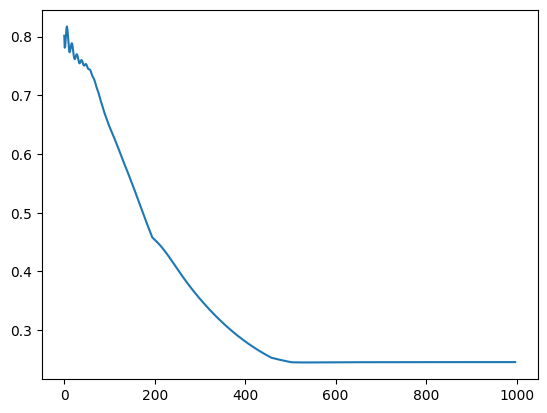

end participant_id/n_participants-1:10/112
time taken: 0.0h - 0.0m - 4.592169761657715s
sampled_data.input_id: tensor([19])
my_module.bias None


In [ ]:
## Graph
def prepare_graph_for_participant(data:pd.DataFrame, participant_id:any, sim_used:str) -> Data:
    # extraction
    subdata = data[data["participant"] == participant_id]

    # similarity
    if sim_used == "ones":
        subdata["test_sim"] = np.ones(len(subdata))
    elif sim_used == "random":
        subdata["test_sim"] = np.random.rand(len(subdata))
    elif sim_used == "original":
        subdata["test_sim"] = subdata["senenceBERT_mpnet_similarity"]
    else:
        raise NotImplementedError("Don't know sim_used =", sim_used)

    participant_graph,translator_word_to_index = raw_data_cleaning.convert_table_to_graph(
        complete_data_table=subdata,
        node_attr_names=["liking","experience"],
        node_label_names=["liking"],
        edge_attr_names=["test_sim"],
        return_word_to_index=True)

    # scaling only the liking
    node_table = raw_data_cleaning.build_node_table(data,["liking"],distinct_id=["participant"])
    scaler_liking = StandardScaler()
    scaler_liking.fit(node_table.liking.to_numpy()[...,np.newaxis])
    transformed_50 = scaler_liking.transform(np.array([[50]]))

    # todo create specific scaler function
    new_x_liking = scaler_liking.transform(participant_graph.x[:,:1])
    new_x_liking -= np.repeat(transformed_50,repeats=participant_graph.num_nodes,axis=0)
    participant_graph.x[:,:1] = torch.Tensor(new_x_liking)

    participant_graph.y = scaler_liking.transform(participant_graph.y)
    participant_graph.y -= np.repeat(transformed_50,repeats=participant_graph.num_nodes,axis=0)
    participant_graph.y = torch.Tensor(participant_graph.y)

    return participant_graph, translator_word_to_index





def run(sim_used:str = "original", dst_file_path:str|None = None):
    ## Data
    #data = data ## TODO

    def nor_function(a,b):
        return (a or b) and not(a and b)

    data["NoExp_Exp"] = data.apply(lambda row: nor_function(row["word1_experience"]>50,row["word2_experience"]>50),axis=1)


    results = {"participant":[],
               "min_train_loss":[],
               "min_train_mae":[],
               "min_train_loss_epoch":[],
               "min_train_mae_epoch":[],
               "end_epoch":[]}

    participant_indices = data["participant"].unique()
    random.shuffle(participant_indices) #TODO: remove
    for participant_id in participant_indices[:1]:
        time_start_participant = time.time()
        print(f"start participant_id/n_participants-1:{participant_id:d}/{len(participant_indices-1):d}")
        
        ## PREPROCESSING ##
        participant_graph, translator_word_to_index = prepare_graph_for_participant(data=data, 
                                                                                    participant_id=participant_id, 
                                                                                    sim_used=sim_used)
        
        # preprocessing 1 - experienced to not experienced
        print("Preprocessing 1")
        preprocessing_cut = preprocessing.CutGroupSendersToGroupReceivers(
            group_senders_mask_fn= lambda x: x["experience"] > 0,
            group_receivers_mask_fn= lambda x: x["experience"] <= 0,
        )

        new_edge_index, new_edge_attr, new_x, new_y = preprocessing_cut.fit_transform(
            edge_index=participant_graph.edge_index.data.numpy(),
            edge_attr=pd.DataFrame(participant_graph.edge_attr.data.numpy(),columns=["test_sim"]),
            x=pd.DataFrame(participant_graph.x.data.numpy(),columns=["liking","experience"]),
            y=pd.DataFrame(participant_graph.y.data.numpy(),columns=["liking"])
        )

        participant_graph.edge_index = torch.Tensor(new_edge_index).to(dtype=torch.int64)
        participant_graph.edge_attr = torch.Tensor(new_edge_attr.values) 
        participant_graph.x = torch.Tensor(new_x.values) 
        participant_graph.y = torch.Tensor(new_y.values) 

        # preprocessing 2 - only not experienced predictions in training
        print("Preprocessing 2")
        node_train_mask = torch.ones(len(participant_graph.x),dtype=torch.bool)
        node_train_mask[participant_graph.x[:,1]>0] = False
        participant_graph.train_mask = node_train_mask
        participant_graph.val_mask = torch.zeros(len(participant_graph.x),dtype=torch.bool)
        
        # preprocessing 3 - two distinct parameters for liking positive and liking negative
        print("Preprocessing 3")
        preprocessing_separate_features = preprocessing.SeparatePositiveNegative(verbose=True, feature_separated="liking")
        x, _ = preprocessing_separate_features.fit_transform(
            x = pd.DataFrame(participant_graph.x.data.numpy(),columns=["liking","experience"])
        )
        participant_graph.x = torch.Tensor(x[["liking_pos","liking_neg"]].values)

        # preprocessing 4 - neighbor loader for convergence to global minimum
        loader = NeighborLoader(
            participant_graph.contiguous(),
            num_neighbors=[60],
            batch_size=1,
            input_nodes=participant_graph.train_mask,
        )
        loader = DataLoader(list(loader), shuffle=True)
        sampled_data = next(iter(loader))

        ## MODEL ##
        print("Model")
        src_content_mask = torch.Tensor([True,True]).to(torch.bool)
        src_edge_mask = torch.Tensor([False,False]).to(torch.bool)
        dst_mask = torch.Tensor([False,False]).to(torch.bool)
        my_module = MyGATConv(
            in_channels=(2,2),
            out_channels=1,
            heads=1,
            negative_slope=0.0,
            add_self_loops=False,
            edge_dim=1,
            dropout=0.0,
            bias=False,
            src_content_mask=src_content_mask,
            src_edge_mask=src_edge_mask,
            dst_content_mask=dst_mask,
            dst_edge_mask=dst_mask)
        print("my_module.bias",my_module.bias)
        
        
        ## Training
        complete_model = GNNFramework(my_module,device)
        complete_model.predict(participant_graph.x,
                               participant_graph.edge_index,
                               participant_graph.edge_attr)

        opt = complete_model.configure_optimizer(lr=1)
        scheduler = complete_model.configure_scheduler(opt,0.1,0.1,10)

        complete_model.predict(participant_graph.x,participant_graph.edge_index,participant_graph.edge_attr)
        description_parameters_init = complete_model.update_node_module.get_description_parameters().copy()
        
        history = complete_model.train([participant_graph],
                                       10000,
                                       1,
                                       opt,
                                       scheduler,
                                       val_dataset=None,
                                       early_stopping_monitor="train_loss",
                                       patience=200)

        plt.plot(history["train_mae"])
        plt.show()
        complete_model.predict(participant_graph.x,participant_graph.edge_index,participant_graph.edge_attr)
        description_parameters_trained = complete_model.update_node_module.get_description_parameters().copy()
        
        ## Save
        results["participant"].append(participant_id)
        results["min_train_loss"].append(np.min(history["train_loss"]))
        results["min_train_mae"].append(np.min(history["train_mae"]))
        results["min_train_loss_epoch"].append(np.argmin(history["train_loss"]))
        results["min_train_mae_epoch"].append(np.argmin(history["train_mae"]))
        results["end_epoch"].append(len(history["train_mae"]))

        for param_name in description_parameters_init.columns:
            if "init_"+param_name in results:
                results["init_"+param_name].append(description_parameters_init[param_name][0])
                results["trained_"+param_name].append(description_parameters_trained[param_name][0])
            else:
                results["init_"+param_name] = [description_parameters_init[param_name][0]]
                results["trained_"+param_name] = [description_parameters_trained[param_name][0]]

        pd.DataFrame(results).to_csv(dst_file_path,index=False)
            
        print(f"end participant_id/n_participants-1:{participant_id:d}/{len(participant_indices-1):d}")
        time_take_participant = (time.time()-time_start_participant)
        print("time taken: {}h - {}m - {}s".format(time_take_participant//(3600),((time_take_participant%3600)//60),((time_take_participant%3600)%60)))

    print("sampled_data.input_id:",sampled_data.input_id)
    print("my_module.bias",my_module.bias)
    return results, participant_graph, complete_model




results, graph, complete_model = run(sim_used="original",dst_file_path="src/experiments/results/04-29_model_pipeline_content-liking_edge-sim_epochs-10000.csv")

In [55]:
[param for param in complete_model.update_node_module.lin_dst_content.parameters()]

[Parameter containing:
 tensor([[-0.0371, -0.4846]], device='cuda:0', requires_grad=True)]

In [56]:
results

{'participant': [36],
 'min_train_loss': [0.0020550874],
 'min_train_mae': [0.031193282],
 'min_train_loss_epoch': [454],
 'min_train_mae_epoch': [454],
 'end_epoch': [463],
 'init_src_content_0': [-0.7493739724159241],
 'trained_src_content_0': [-5.996600151062012],
 'init_src_content_1': [0.40897414088249207],
 'trained_src_content_1': [-4.18192720413208],
 'init_att_src_edge_0': [1.0],
 'trained_att_src_edge_0': [1.0],
 'init_src_edge_0': [-0.17355701327323914],
 'trained_src_edge_0': [-4.338362216949463],
 'init_src_edge_1': [0.3059164881706238],
 'trained_src_edge_1': [-0.5895199179649353],
 'init_full_src_edge_0': [-0.17355701327323914],
 'trained_full_src_edge_0': [-4.338362216949463],
 'init_full_src_edge_1': [0.3059164881706238],
 'trained_full_src_edge_1': [-0.5895199179649353],
 'init_dst_content_0': [-0.037134911864995956],
 'trained_dst_content_0': [-0.037134911864995956],
 'init_dst_content_1': [-0.48461204767227173],
 'trained_dst_content_1': [-0.48461204767227173],
 'in

In [29]:
graph.x

tensor([[ 0.0000, -1.1798],
        [ 0.8773,  0.0000],
        [ 0.0000, -0.4235],
        [ 0.8470,  0.0000],
        [ 0.0000, -0.2723],
        [ 0.0000, -1.1193],
        [ 0.0000, -0.0303],
        [ 0.9378,  0.0000],
        [ 0.0303,  0.0000],
        [ 0.0000, -0.1513],
        [ 0.0000, -1.5125],
        [ 1.3613,  0.0000],
        [ 0.6353,  0.0000],
        [ 0.0000, -0.8470],
        [ 0.0000, -1.2705],
        [ 0.5445,  0.0000],
        [ 0.0303,  0.0000],
        [ 0.0000, -0.7563],
        [ 0.9983,  0.0000],
        [ 0.0000, -0.5445],
        [ 0.0000, -0.2723],
        [ 0.0000, -0.3328],
        [ 0.0000, -1.3915],
        [ 0.0000, -1.5125],
        [ 0.9378,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000, -0.6050],
        [ 0.0000, -1.5125],
        [ 0.0000, -1.5125],
        [ 0.0000, -0.3630],
        [ 0.0000, -0.3630],
        [ 0.5143,  0.0000],
        [ 0.0000, -1.1495],
        [ 0.8773,  0.0000],
        [ 0.0000, -0.9680],
        [ 0.8168,  0

In [82]:
from torch_geometric.loader import NeighborLoader, DataLoader

In [83]:
loader = NeighborLoader(
    graph.contiguous(),
    # Sample 30 neighbors for each node for 2 iterations
    num_neighbors=[60],
    # Use a batch size of 128 for sampling training nodes
    batch_size=10,
    input_nodes=graph.train_mask,
)

loader = DataLoader(list(loader), shuffle=True)


In [84]:
sampled_data = next(iter(loader))
print(sampled_data.batch_size)
print(len(loader))

1
5


In [85]:
graph.train_mask.sum()

tensor(41)

In [75]:
sampled_data

DataBatch(x=[60, 2], edge_index=[2, 488], edge_attr=[488, 1], y=[60, 1], x_names=[1], edge_attr_names=[1], y_names=[1], train_mask=[60], val_mask=[60], n_id=[60], e_id=[488], num_sampled_nodes=[1], num_sampled_edges=[1], input_id=[10], batch_size=[1], batch=[60], ptr=[2])

In [76]:
sampled_data.input_id

tensor([ 0,  1,  2,  4,  5,  8, 10, 11, 12, 13])

In [ ]:
import torch
from torch_sparse import coalesce

index = torch.tensor([[1, 0, 1, 0, 2, 1],
                      [0, 1, 1, 1, 0, 0]])
value = torch.Tensor([[1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7]])

index, value = coalesce(index, value, m=3, n=2)

In [ ]:
import torch

from torch_geometric.nn.dense.linear import Linear



torch.nn.Linear(1, 1 * 1, bias=False,weight_initializer="glorot")

TypeError: Linear.__init__() got an unexpected keyword argument 'weight_initializer'